In [1]:
import datetime

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import seaborn_image as isns

In [3]:
comnist_data = np.loadtxt('./../datasets/latin_data.csv', delimiter=",", dtype="float32")
comnist_label = np.loadtxt('./../datasets/latin_label.csv', delimiter=",", dtype="float32")

In [ ]:
import string

i = np.random.randint(comnist_data.shape[0])
my_letter = np.flip(comnist_data[i].reshape(28, 28), 0)
my_label = string.ascii_uppercase[int(comnist_label[i])]
print(f"Displaying letter {my_label}")
isns.imgplot(my_letter, cmap="gray", describe=True)

In [4]:
import os
from torch.utils.data import Dataset
from torchvision.io import read_image


class СoMNISTDataset(Dataset):
    def __init__(
        self,
        labels_dir,
        data_dir,
        transform=None,
        target_transform=None
    ):
        self.img_labels = pd.read_csv(labels_dir)
        self.img_features = pd.read_csv(data_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = np.asarray(self.img_features.iloc[idx], dtype=np.float32).reshape(28,28)
        label = self.img_labels.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [5]:
import torchvision.transforms.functional


training_samples: 10897
validation_samples: 1924

0


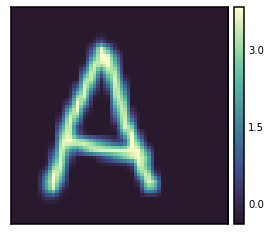

In [39]:
comnnist_dataset = СoMNISTDataset(
    labels_dir='./../datasets/latin_label.csv',
    data_dir='./../datasets/latin_data.csv',
    transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64,64)),
        transforms.functional.vflip,
        transforms.ToTensor(),
        transforms.Normalize(mean=0.0942,
                             std=0.2352)
    ])
)
training_samples = int(len(comnnist_dataset) * 0.85)
validation_samples = len(comnnist_dataset) - training_samples
print(f'''
training_samples: {training_samples}
validation_samples: {validation_samples}
''')

isns.imshow(comnnist_dataset[100][0].squeeze(0))
print(comnnist_dataset[100][1])

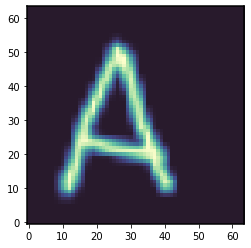

In [40]:
image = comnnist_dataset[100][0]
plt.imshow(image.permute(1, 2 ,0))

In [41]:
imgs = torch.stack([img_t for img_t, _ in comnnist_dataset], dim=3)
imgs.shape

torch.Size([1, 64, 64, 12821])

In [42]:
imgs.view(1, -1).mean(dim=1)

tensor([-9.0722e-05])

In [43]:
imgs.view(1, -1).std(dim=1)

tensor([0.9999])

In [44]:
train_set, val_set = torch.utils.data.random_split(
    comnnist_dataset,
    [training_samples, validation_samples],
    generator=torch.Generator().manual_seed(42))

In [45]:
# TODO: unsure to refactor batch_size to be in separate variable
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)

<ipython-input-46-03b4981adefd>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])


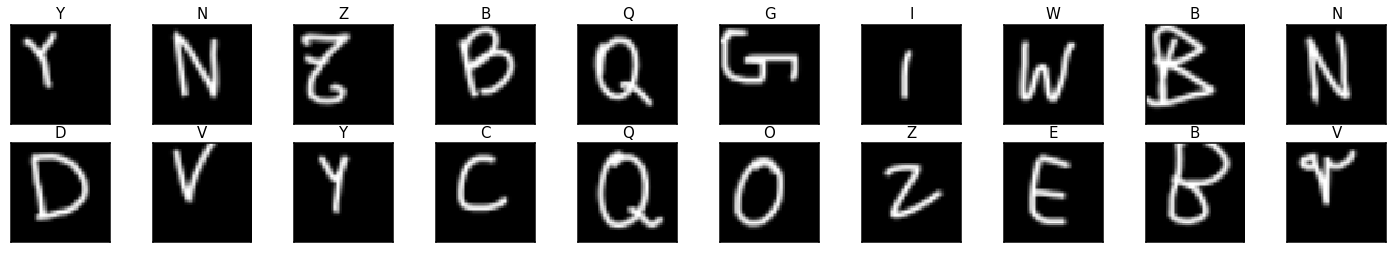

In [46]:
data_i = iter(train_loader)
images, labels = data_i.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(string.ascii_uppercase[int(labels[idx].item())])

In [ ]:
img = np.squeeze(images[0])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max() / 2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] != 0 else 0
        ax.annotate(str(val), xy=(y, x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y] < thresh else 'black')




In [47]:
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
class Net(nn.Module):
    def __init__(self, n_out=26):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, n_out)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out

# initialize the NN
model = Net()
print(model)

In [48]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 26, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [49]:
img, _ = comnnist_dataset[0]
img_batch = img.unsqueeze(0)



<AxesSubplot:>

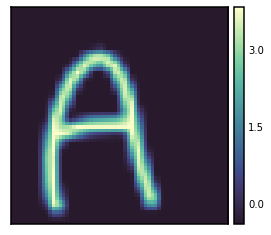

In [50]:
isns.imshow(img.permute(1,2,0))

In [51]:
alexnet = AlexNet()
out = alexnet(img.unsqueeze(0))
out

tensor([[-0.0147, -0.0066, -0.0038, -0.0216, -0.0125,  0.0239,  0.0070, -0.0409,
          0.0079, -0.0033,  0.0185, -0.0069, -0.0031,  0.0096, -0.0033, -0.0062,
         -0.0019,  0.0079,  0.0022, -0.0116, -0.0138, -0.0198, -0.0093, -0.0045,
         -0.0016,  0.0115]], grad_fn=<AddmmBackward>)

In [ ]:
out = model(img.unsqueeze(0))
out

In [52]:
## Specify loss and optimization functions

# specify loss function
loss_fn = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(alexnet.parameters(), lr=1e-3)

In [54]:
n_epochs = 200

alexnet.train()

for epoch in range(n_epochs):
    loss_train = 0.0
    loss_val = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        outputs = alexnet(images)
        train_loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        loss_train += train_loss.item()

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = alexnet(images)
            val_loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            loss_val += val_loss.item()

    
    print(f'{datetime.datetime.now()} Epoch {epoch}, Training loss {loss_train / len(train_loader)}' +
          f', Validation loss {loss_val / len(val_loader)}, Accuracy {correct / total}')
    
    if loss_val / len(val_loader) <= 0.3 or loss_train / len(train_loader) <=0.15:
        break

2021-11-21 23:59:22.712318 Epoch 0, Training loss 3.289222855900609, Validation loss 3.2500330209732056, Accuracy 0.060810810810810814
2021-11-22 00:02:24.976052 Epoch 1, Training loss 2.932395630104597, Validation loss 2.535722553730011, Accuracy 0.1392931392931393
2021-11-22 00:05:30.905180 Epoch 2, Training loss 2.38957517091618, Validation loss 2.1923305988311768, Accuracy 0.21413721413721415
2021-11-22 00:08:24.416318 Epoch 3, Training loss 1.9542507986689723, Validation loss 1.6765945106744766, Accuracy 0.3866943866943867
2021-11-22 00:11:13.068523 Epoch 4, Training loss 1.3056540960489318, Validation loss 1.085840716958046, Accuracy 0.6496881496881497
2021-11-22 00:13:58.488446 Epoch 5, Training loss 0.751035577336023, Validation loss 0.6602261587977409, Accuracy 0.7884615384615384
2021-11-22 00:16:31.644471 Epoch 6, Training loss 0.4787299840949302, Validation loss 0.4813787154853344, Accuracy 0.854989604989605
2021-11-22 00:18:49.555021 Epoch 7, Training loss 0.362253321118133

In [ ]:
import seaborn as sns
import pandas as pd

data = pd.DataFrame(dict(epoch=epoch_list, loss=train_loss_list))
sns.set_theme(style="darkgrid")

fig = sns.relplot(
    x='epoch'
    , y='loss'
    , kind='scatter'
    , data=data
)
fig.savefig("output_3_80_relu.png")

<ipython-input-55-9a6fdc94f10e>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])


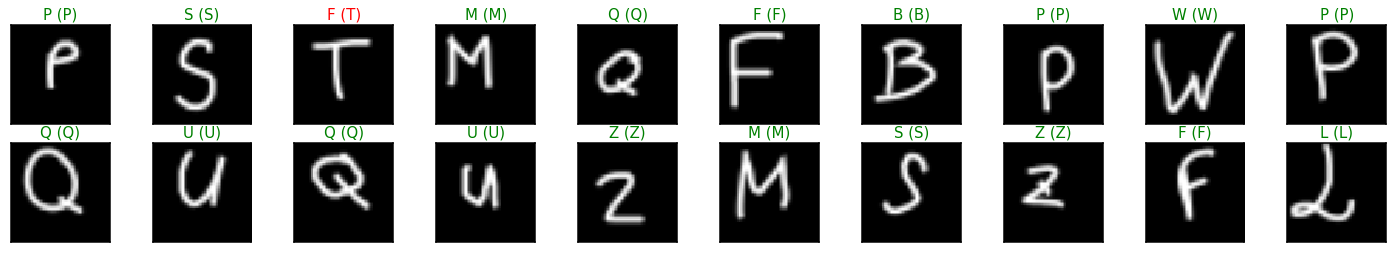

In [55]:
import string
# obtain one batch of test images
loader = torch.utils.data.DataLoader(val_set, batch_size=20, shuffle=True)
dataiter = iter(loader)
images, labels = dataiter.next()

# get sample outputs
output = alexnet(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(
        "{} ({})".format(string.ascii_uppercase[int(preds[idx].item())],string.ascii_uppercase[int(labels[idx].item())]),
        color=("green" if preds[idx] == labels[idx] else "red"))




In [ ]:
# import torch
# torch.cuda.is_available()

In [ ]:
# torch.zeros(1).cuda()


In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()  # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(100):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)')

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

## Dimensionality Reduction using Supervised UMAP
Using UMAP implementation from sci-kit learn library

In [94]:
import plotly.express as px
import matplotlib.pyplot as plt

from umap import UMAP

In [129]:
reducer = UMAP(
    n_neighbors=100,
    n_components=3,
    n_epochs=1000,
    min_dist=0.5,
    local_connectivity=10,
    random_state=42
)

In [130]:
X_train_res = 0
X_test_res = 0
batch = 0

reducer_train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=True)
reducer_val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=False)

for images, labels in reducer_train_loader:
    # TODO: Notate batch size trick
    batch_size = images.shape[0]
    images_a = images.reshape(batch_size,-1).numpy()
    labels_a = labels.numpy()
    X_train_res = reducer.fit_transform(images_a, labels_a)

    break


print(f'''Shape of X_train_res: {X_train_res.shape}''')

Shape of X_train_res: (10897, 3)


In [112]:
def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label
    # so, we can maintain consistent colors for digits across multiple graphs

    # Concatenate X and y arrays
    arr_concat=np.concatenate((X, y.reshape(y.shape[0],1)), axis=1)
    # Create a Pandas dataframe using the above array
    df=pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    #--------------------------------------------------------------------------#

    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(title_text='UMAP',
                      showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1),
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))

    fig.show()

In [131]:
for images, labels in reducer_val_loader:
    batch_size = images.shape[0]
    images_a = images.reshape(batch_size, -1).numpy()
    X_test_res = reducer.transform(images_a)
    chart(X_test_res, labels)

    break

### Artificial Neural Network Model
That can distinct our reduced dataset by UMAP, from 3 input features to 26 classes

In [132]:
class ReducedLatinNet(nn.Module):
    def __init__(self, num_classes: int = 26, dropout: float = 0.5) -> None:
        super().__init__()
        self.fc1 = nn.Linear(3, 52)
        self.fc1_dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(52, 52)
        self.fc2_dropout = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(52, num_classes)

    def forward(self, x):
        out = self.fc1(torch.tanh(x))
        out = self.fc1_dropout(out)
        out = self.fc2(torch.tanh(out))
        out = self.fc2_dropout(out)
        out = self.fc3(torch.tanh(out))
        return out

reducedLatinNet = ReducedLatinNet()

In [133]:
reducedLatinNet

ReducedLatinNet(
  (fc1): Linear(in_features=3, out_features=52, bias=True)
  (fc1_dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=52, out_features=52, bias=True)
  (fc2_dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=52, out_features=26, bias=True)
)